In [1]:
import sys
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.spatial import ConvexHull
from sklearn.manifold import MDS #If you want the scikit learn mds
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay,classification_report
import HiCtoolbox
from hmmlearn import hmm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import h5py



In [2]:
# important functions
def binning_intra(filename,R):
    contacts=pd.read_csv(filename, sep="\t",header=None)    # <-  here  acces to data ,write the filename you wish  
    contacts=np.int_(np.array(contacts))
    contacts=np.concatenate((contacts,np.transpose(np.array([contacts[:,1],contacts[:,0],contacts[:,2]]))), axis=0)#flipping rows to keep full data  @ taken from Leopold
    contacts= sparse.coo_matrix( (contacts[:,2], (contacts[:,0],contacts[:,1]))) # need sparse becaus eof big volume of some matrices
    binned_map=HiCtoolbox.bin2d(contacts,R,R) #!become csr sparse array, taken from leopold
    del contacts
    
  
    return binned_map 

def binning_inter(filename,R):
    contacts=pd.read_csv(filename, sep="\t",header=None)    # <-  here  acces to data ,write the filename you wish  
    contacts=np.int_(np.array(contacts))
    contacts= sparse.coo_matrix( (contacts[:,2], (contacts[:,0],contacts[:,1]))) # need sparse becaus eof big volume of some matrices
    binned_map=HiCtoolbox.bin2d(contacts,R,R) #!become csr sparse array, taken from leopold
    del contacts
    return binned_map
def contact_map(R,intra,inter=None):
   
    if len(intra)==1:
        binned_map=binning_intra(intra[0],R)
        return binned_map
    else:
        intra_maps=[]
        inter_maps=[]
        inter_maps_trans=[]
        for filename in intra:
            binned_map=binning_intra(filename,R)
            intra_maps.append(binned_map.toarray())
        for  filename in inter:
            binned_map=binning_inter(filename,R)
            inter_maps.append(binned_map.toarray())
            inter_maps_trans.append(binned_map.toarray().T)
        hstock=[]
        vstock=[]
        for i in range(len(intra)):
            hstock.append(np.hstack((intra_maps[i],*inter_maps[:(len(intra)-i)])))
            vstock.append(np.vstack((intra_maps[i],*inter_maps_trans[:(len(intra)-i)]))) 
            inter_maps=inter_maps[(len(intra)-i):]
            inter_maps_trans=inter_maps_trans[(len(intra)-i):]
        complete_array=np.zeros((vstock[0].shape[0],vstock[0].shape[0])) 
        x,y=0,0
        for i in range((len(intra))):
           
            complete_array[x:(x+hstock[i].shape[0]),(hstock[0].shape[1]-hstock[i].shape[1]):hstock[0].shape[1]]=hstock[i]
            complete_array[(vstock[0].shape[0]-vstock[i].shape[0]):vstock[0].shape[0],y:(y+vstock[i].shape[1])]=vstock[i]
            x=hstock[i].shape[0]
            y=vstock[i].shape[1]
            
        complete_array=sparse.csr_matrix(complete_array)    
        return complete_array
    
def filter(binned_map):
    filtered_map,bin_sel=HiCtoolbox.filteramat(binned_map)
    
    return filtered_map,bin_sel

def SCN(filtered_map):
    contact_map=HiCtoolbox.SCN(filtered_map.copy()) 
    return contact_map

def diagonals(contact_map):
    mean=[]
    n=contact_map.shape[0]
    new_contact=np.zeros((n,n))

    mean=[np.mean(contact_map.diagonal(i)) for i in range(-n+1,n)]
    for i in range(n):
        for j in range(n):
            new_contact[i, j] = contact_map[i,j]/mean[j-i+n-1]
    new_contact
    return new_contact
    
def correlations(contact_map):
    corr_mat=np.corrcoef(np.array(contact_map)) # calcul of Pearson correlation
    corr_mat=np.nan_to_num(corr_mat, nan=0.0)
   
    
   

    return corr_mat

In [20]:
def pipeline(binned_map):
    
    filtered_map,bin_saver=filter(binned_map)
    binned_df=pd.DataFrame(binned_map.toarray())
    contact_map_filtered=SCN(filtered_map)
    contact_map=diagonals(contact_map_filtered)
    contact_map=contact_map-np.diag(np.diag(contact_map))
    plt.figure(figsize=(10, 10)) 
    sns.heatmap(contact_map, norm=LogNorm())
    corr_mat=correlations(contact_map)
    binned_df.iloc[:,:]=0
    binned_df.iloc[bin_saver,bin_saver]=corr_mat
  
    
    return corr_mat,binned_df,bin_saver, filtered_map
    
    
    

In [21]:
intra=["chr22_100kb.txt"] #  chromosome contact map 
inter=[] # several chromosomes contact maps if inter
R=100000 # 
alpha=0.227
EpiGfilename="E116_15.bed"


In [22]:
complete_array=contact_map(R,intra,inter)
complete_array

<513x513 sparse matrix of type '<class 'numpy.intc'>'
	with 118508 stored elements in Compressed Sparse Row format>

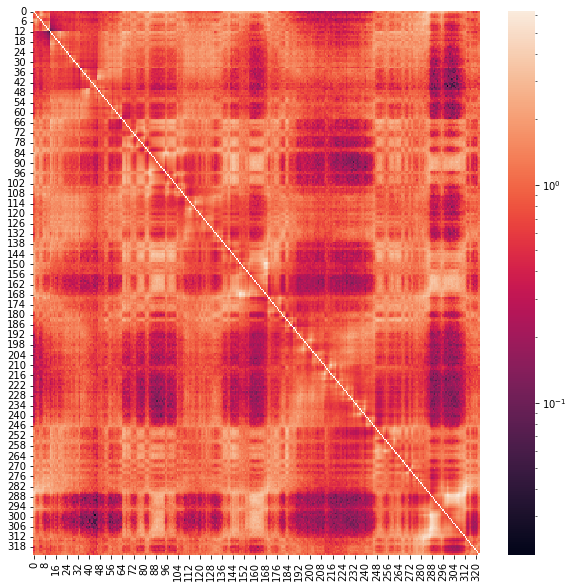

In [23]:
corr_mat,binned_df,bin_saver,filtered_map=pipeline(complete_array) # gives correlation matrix withou and with filtered bins,  saved bins 

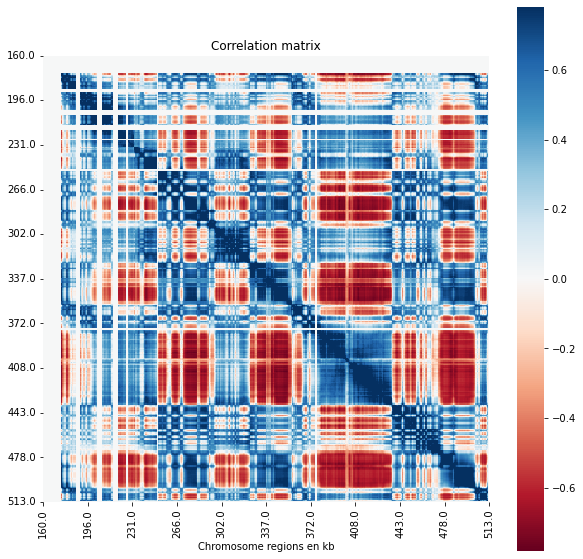

In [39]:
# heatmap of correlation matrix considering filtered bins
plt.figure(figsize=(10, 10)) 
border=np.where(complete_array.toarray()>0)[0][0]  # elimation of zero zone 
nr_of_sticks=11
yticklabels = np.ceil(np.linspace(border,binned_df.shape[0],nr_of_sticks))
xticklabels = np.ceil(np.linspace(border,binned_df.shape[0],nr_of_sticks))
yticks = np.linspace(0,binned_df.shape[0]-border,nr_of_sticks)
xticks = np.linspace(0,binned_df.shape[0]-border,nr_of_sticks)
v=np.min([abs(np.min(np.min(binned_df))),abs(np.max(np.max(binned_df)))]) # color bar cutt of 

ax=sns.heatmap(binned_df.iloc[border:,border:],cmap="RdBu",center=0,square=True,vmin=-1*v,vmax=v)
ax.set_yticks(yticks)
ax.set_xticks(xticks)
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
plt.xlabel('Chromosome regions en kb')
ax.set_title("Correlation matrix")
plt.show()

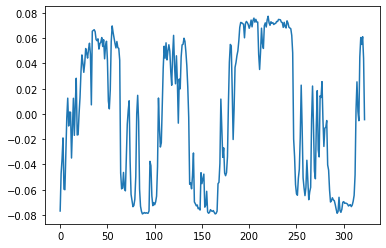

In [41]:
# EIGENVECTORS
eigenvalue, eigenvector=np.linalg.eig(corr_mat)
eigenvector=eigenvector.T
plt.plot(np.arange(len(eigenvector[0])),-1*eigenvector[0])
plt.show()
filename="Chr22_vectorp" # name of txt file  to export
np.savetxt(filename,eigenvector[0])
#print(np.where([eigenvector[0]==np.min(eigenvector[0])]),len(eigenvector[0]),-1*eigenvector[0])


In [42]:
# eigenvector with filtered bins
ev=-1*eigenvector[0]
eigenvectorlong=-1*np.ones(binned_df.shape[0])
for i in range(ev.shape[0]):
    if np.sign(ev[i])==-1:
        ev[i]=0
    else:
        ev[i]=1
eigenvectorlong[bin_saver]=ev
len(eigenvectorlong)

513

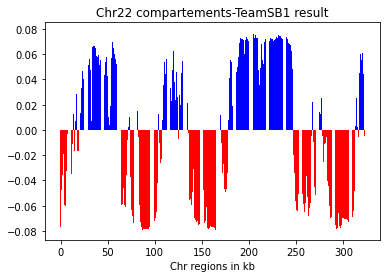

In [44]:
# eigenvectors in bar plot
colors=[]
for i in range(eigenvector.shape[0]):
    if eigenvector[0][i] >0:
        colors.append("red")
    if  eigenvector[0][i] <=0:
        colors.append("blue")
plt.bar(np.arange(len(eigenvector[0])),-1*eigenvector[0],color=colors)
plt.xlabel("Chr regions in kb")
plt.title("Chr22 compartements-TeamSB1 result")
plt.show()


In [45]:
compartements=np.sign(eigenvector[0])
filename="Chr22_cpts" # name export txt file compartement
np.savetxt(filename,compartements)

#compartements

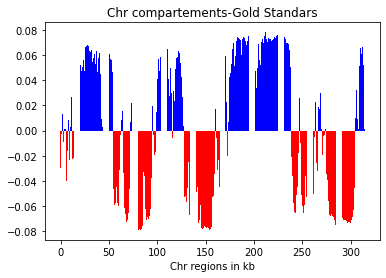

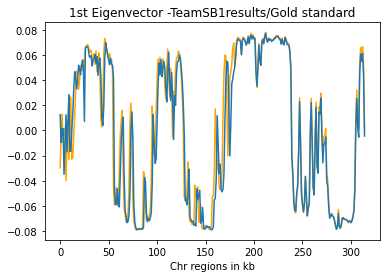

In [48]:
# COMPARISON WITH GOLD STANDARD

gold_chr_vp=pd.read_csv("chr22_VP.txt", sep="\t",header=None)  # read gold standard file eigenvector watch out for resolution 
st_chr_vp=gold_chr_vp.drop(gold_chr_vp[gold_chr_vp.iloc[:,0]==-1].index) # filtarated gold standard values -1 drop out
#print(np.where([st_chr_vp==np.max(st_chr_vp)]),len(st_chr_vp),st_chr_vp)
#st_chr_vp=gold_chr_vp.iloc[bin_saver] # filtarted gold standard using bin_saver
gold_chr_cpt=pd.read_csv("chr22_compartiment.txt", sep="\t",header=None) #read gold standard file comparts
st_chr_cpt=gold_chr_cpt.drop(gold_chr_cpt[gold_chr_cpt.iloc[:,0]==-1].index) # filtarated gold standard values -1 drop out
#st_chr_cpt=gold_chr_cpt.iloc[bin_saver]  #filtrated gold standard using bin saver

# ploting gold standard eigenvector as barplot 
colors_gold=[]
for i in range(len(st_chr_vp.iloc[:,0])):
    if st_chr_vp.iloc[i,0] >0:
        colors_gold.append("blue")
    if  st_chr_vp.iloc[i,0] <=0:
        colors_gold.append("red")
plt.bar(np.arange(len(st_chr_vp.iloc[:,0])),st_chr_vp.iloc[:,0],color=colors_gold)
plt.title("Chr compartements-Gold Standars")
plt.xlabel("Chr regions in kb")
plt.show()

plt.plot(np.arange(len(st_chr_vp.iloc[:,0])),st_chr_vp.iloc[:,0],color='orange') # gold standard in orange
plt.title("1st Eigenvector - Gold Standard")

#plt.plot(np.arange(len(eigenvector[0][0:])),-1*eigenvector[0][0:]) # team SB1 in blue
plt.plot(np.arange(len(eigenvector[0][8:])),-1*eigenvector[0][8:])  # there is a shift of 8 bins  
plt.title ( "1st Eigenvector -TeamSB1results/Gold standard")
plt.xlabel("Chr regions in kb")

plt.show()

In [49]:
# precision , recall f-score not filtered vector
y_true = eigenvectorlong
y_pred = gold_chr_cpt[:-2]
target_names = ['Active', 'Inactive', 'No cmt']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Active       0.92      0.96      0.94       190
    Inactive       0.94      0.79      0.86       158
      No cmt       0.83      0.92      0.87       165

    accuracy                           0.89       513
   macro avg       0.90      0.89      0.89       513
weighted avg       0.90      0.89      0.89       513



In [50]:
# precision , recall, f-score , filtered vector
y_true = -1*np.sign(eigenvector[0][8:]) 
for i in range(y_true.shape[0]):
    if y_true[i]==-1:
        y_true[i]=0
        
y_pred= st_chr_cpt

target_names = ['Active', 'Inactive']
print(classification_report(y_true, y_pred, target_names=target_names))


[0. 1.]
              precision    recall  f1-score   support

      Active       0.93      0.83      0.88       150
    Inactive       0.86      0.95      0.90       165

    accuracy                           0.89       315
   macro avg       0.89      0.89      0.89       315
weighted avg       0.89      0.89      0.89       315



In [51]:
# GENE DENSITY
    
filename = "chr22.hdf5"  # here gene density file reading

def gene_density(filename):
    with h5py.File(filename, "r") as f:
        # List all groups
        print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())[0]

    # Get the data
        data = list(f[a_group_key])
    
    gene_density=[]
    for i in range(len(data)):
        gene_density.append(data[i][0])

    plt.plot(gene_density)
    plt.show()
    return gene_density

Keys: <KeysViewHDF5 ['data']>


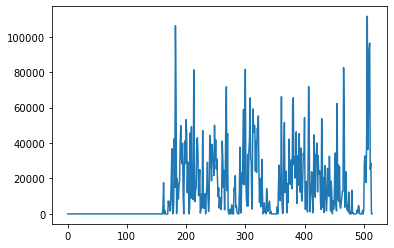

In [52]:
gene_den=gene_density(filename)

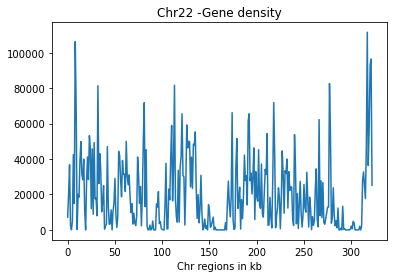

In [53]:
# without centromer and rejected locations
gen_den=(np.array(gene_den))[bin_saver]
plt.title("Chr22 -Gene density")
plt.xlabel("Chr regions in kb")
plt.plot(gen_den)
plt.show()

In [54]:
# precision, recall, f-score, gene density 
#compartement criterium
mean=np.median(gen_den)
for i in range(len(gen_den)):
    if gen_den[i]>=mean:
        gen_den[i]=1
    else:
        gen_den[i]=0
mean
    

13499.0

In [55]:
y_true = -1*np.sign(eigenvector[0]) 
for i in range(y_true.shape[0]):
    if y_true[i]==-1:
        y_true[i]=0
        
y_pred= gen_den

target_names = ['Active', 'Inactive']
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

      Active       0.70      0.71      0.70       158
    Inactive       0.72      0.70      0.71       165

    accuracy                           0.71       323
   macro avg       0.71      0.71      0.71       323
weighted avg       0.71      0.71      0.71       323



In [56]:
# Hidden Markov Chain
scores=[]
for i in range(2,10):
    model = hmm.GaussianHMM( n_components=i,covariance_type="full", n_iter=100)
    model.fit(corr_mat)
    scores.append(model.score(corr_mat))

opt_compt=np.argmax(scores)

Fitting a model with 105301 free scalar parameters with only 104329 data points will result in a degenerate solution.
Fitting a model with 157955 free scalar parameters with only 104329 data points will result in a degenerate solution.
Fitting a model with 210611 free scalar parameters with only 104329 data points will result in a degenerate solution.
Fitting a model with 263269 free scalar parameters with only 104329 data points will result in a degenerate solution.
Fitting a model with 315929 free scalar parameters with only 104329 data points will result in a degenerate solution.
Fitting a model with 368591 free scalar parameters with only 104329 data points will result in a degenerate solution.
Fitting a model with 421255 free scalar parameters with only 104329 data points will result in a degenerate solution.
Fitting a model with 473921 free scalar parameters with only 104329 data points will result in a degenerate solution.


In [58]:
opt_model=hmm.GaussianHMM( n_components=3,covariance_type="full", n_iter=100)
opt_model.fit(corr_mat)
hmm_cpts=opt_model.predict(corr_mat)

Fitting a model with 157955 free scalar parameters with only 104329 data points will result in a degenerate solution.


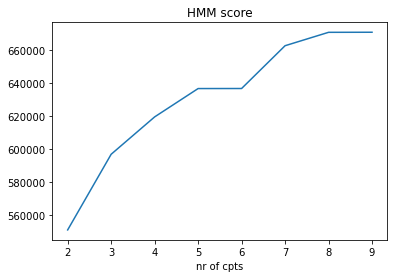

In [59]:

plt.plot(np.arange(2,len(scores)+2),scores)
plt.title("HMM score")
plt.xlabel("nr of cpts")
plt.show()

In [69]:
hmm_colors=[]
for i in range(hmm_cpts.shape[0]):
    if hmm_cpts[i]==2:
        hmm_colors.append("green")
    if  hmm_cpts[i]==1:
        hmm_colors.append("red")
    if  hmm_cpts[i] ==0:
        hmm_colors.append("blue")
 
        
len(hmm_colors)

323

In [62]:
# EPIGENETIC MARKS  # otional
def epigen(chromosome, mark,R,threshold):  # takes specific chromosome and mark
    epigen=pd.read_csv("E116_15.bed", sep="\t",header=None)
    chr_epigen=epigen.loc[epigen[0] == chromosome]
    chr_mark=chr_epigen.loc[chr_epigen[3] == mark] 
    mark=np.int_(np.array(chr_mark.iloc[:,1:]))
    mark=np.concatenate((mark,np.transpose(np.array([mark[:,1],mark[:,0],mark[:,2]]))), axis=0)#flipping rows to keep full data  @ taken from Leopold
    mark= sparse.coo_matrix( (mark[:,2], (mark[:,0],mark[:,1]))) # need sparse becaus eof big volume of some matrices
    binned_map_mark=HiCtoolbox.bin2d(mark,R,R)
    mark_map=binned_map_mark.toarray()
    mark_map=np.where(mark_map>=threshold)
    mark_density=np.sum(mark_map,axis=0)
    plt.bar(np.arange(len(mark_density)), mark_density)
    plt.show()
    
    return binned_map_mark


C:\Users\oktaw\AppData\Local\Temp/ipykernel_3036/4022126964.py:1: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  epigen("chr22","9",100000,60) # precise chromosome and mark


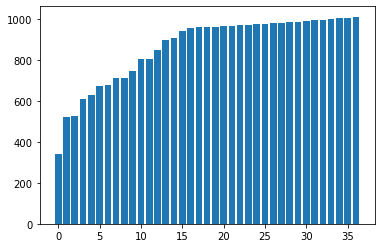

<513x513 sparse matrix of type '<class 'numpy.intc'>'
	with 216 stored elements in Compressed Sparse Row format>

In [63]:
epigen("chr22","9",100000,60) # precise chromosome and mark 

In [64]:
 # 3D distance matrix
contact_map=HiCtoolbox.SCN(filtered_map.copy()) 
contact_map=np.asarray(contact_map)**alpha #now we are not sparse at all
dist_matrix = HiCtoolbox.fastFloyd(1/contact_map) #shortest path on the matrix
dist_matrix=dist_matrix-np.diag(np.diag(dist_matrix))#remove the diagonal
dist_matrix=(dist_matrix+np.transpose(dist_matrix))/2
XYZ,E=HiCtoolbox.sammon(dist_matrix, 3)

epoch = 1 : E = 0.0281948332
epoch = 2 : E = 0.0279470435
epoch = 3 : E = 0.0264462486
epoch = 4 : E = 0.0260507589
epoch = 5 : E = 0.0222207147
epoch = 6 : E = 0.0213625416
epoch = 7 : E = 0.0212890110
epoch = 8 : E = 0.0208872844
epoch = 9 : E = 0.0207403116
epoch = 10 : E = 0.0200048389
epoch = 11 : E = 0.0196419633
epoch = 12 : E = 0.0194173153
epoch = 13 : E = 0.0193727635
epoch = 14 : E = 0.0167169392
epoch = 15 : E = 0.0159087337
epoch = 16 : E = 0.0133458653
epoch = 17 : E = 0.0106861422
epoch = 18 : E = 0.0106245665
epoch = 19 : E = 0.0083821994
epoch = 20 : E = 0.0083784469
epoch = 21 : E = 0.0083749028
epoch = 22 : E = 0.0082642334
epoch = 23 : E = 0.0079456137
epoch = 24 : E = 0.0077031011
epoch = 25 : E = 0.0076271932
epoch = 26 : E = 0.0075390349
epoch = 27 : E = 0.0074255090
epoch = 28 : E = 0.0073852002
epoch = 29 : E = 0.0073119155
epoch = 30 : E = 0.0072926094
epoch = 31 : E = 0.0072730231
epoch = 32 : E = 0.0072623846
epoch = 33 : E = 0.0072586001
epoch = 34 : E = 0.

In [65]:
A=pd.read_csv("chr22_100kb.txt", sep="\t",header=None) # here once again filename
A=np.int_(np.array(A))
A=np.concatenate((A,np.transpose(np.array([A[:,1],A[:,0],A[:,2]]))), axis=0)#build array at pb resolution
A = sparse.coo_matrix( (A[:,2], (A[:,0],A[:,1])))
LENTEST=np.shape(A)[0]
del A


In [66]:
# Leopolds code for colors of marks
selectedmark=9 # here you select mark  
color=pd.read_csv(EpiGfilename,delimiter='\t',header=None,names=[1,2,3,4])
color=color[color[1]=='chr22']   #take only chr of interest
color[4]=color[4].astype("int")
number=color[4].max() #number of color in the file
print(number)
#color_vec=np.zeros((LENTEST,number+1))#build array at pb resolution LENchr * number of color
color_vec = sparse.csr_matrix((LENTEST, number+1), dtype=int)
color_vec=color_vec.toarray()
print(color_vec.shape)
i=0

while i<np.shape(color)[0]:
    
	color_vec[int(color[2].iloc[i]):int(color[3].iloc[i]),int(color[4].iloc[i])]=1
	i+=1
color_v=sparse.csr_matrix(color_vec)

color_bins=HiCtoolbox.bin2d(color_v,R,1)
color_bins=color_bins/np.amax(color_bins)

print('Bp cover by this mark, has to be >0 :',np.sum(color_bins[:,selectedmark]) )

color_chr=color_bins[bin_saver] #filter the epi by removed bin in HiC
color_chr=color_chr[:,selectedmark] #now color2 is 1D
color_chr=np.float64(color_chr.todense()) #type issue



15
(51200001, 16)
Bp cover by this mark, has to be >0 : 12.444000000000003


In [67]:
# import to 3D pdb file to use with Pymol
print("Output shape : ",np.shape(XYZ),np.shape(color_chr))
#point rescale
hull=ConvexHull(XYZ)
scale=100/hull.area**(1/3)
XYZ=XYZ*scale
HiCtoolbox.writePDB('3Dcolors_'+str(alpha)+'.pdb',XYZ,color_chr) #  colors of epigemic mark or compartemenst


Output shape :  (323, 3) (323, 1)


In [ ]:
''''
# colors of compartement 
color_chr=np.array(colors)
for i in range(color_chr.shape[0]):
    if color_chr[i]=="red":
        color_chr[i]=1
    if  color_chr[i]=="blue":
        color_chr[i]=-1'''

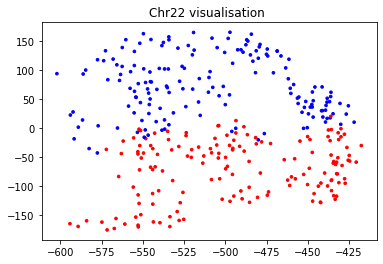

In [70]:
# 2D 
plt.scatter(XYZ[:,0],XYZ[:,1],color=colors,s=7) # chosse axis you need
plt.title("Chr22 visualisation ")
plt.show()

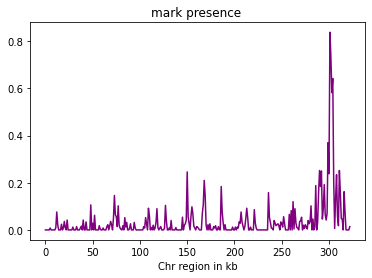

In [72]:

color_chr
plt.plot(np.arange(len(color_chr)),color_chr,color="purple")
plt.title("mark presence ")
plt.xlabel("Chr region in kb")
plt.show()


In [74]:
# compartement criterium 
cchr=[]
for i in range(len(color_chr)):
    cchr.append(color_chr[i,0])

    
mean=np.mean(cchr)

for i in range(len(cchr)):
    if color_chr[i]>=mean:
        cchr[i]=1
    if color_chr[i]<mean:
        cchr[i]=0
print(mean)

0.0374984520123839


In [75]:
# precision, recal, f score, epigenetic mark
y_true = -1*np.sign(eigenvector[0]) 
for i in range(y_true.shape[0]):
    if y_true[i]==-1:
        y_true[i]=0
        
y_pred= cchr

target_names = ['Active', 'Inactive']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Active       0.43      0.68      0.53       158
    Inactive       0.33      0.15      0.21       165

    accuracy                           0.41       323
   macro avg       0.38      0.41      0.37       323
weighted avg       0.38      0.41      0.36       323



In [ ]:
c_chr=[]
for i in range(color_chr.shape[0]):
    if color_chr[i]>0:
        c_chr.append('blue')
    if color_chr[i]==0:
        c_chr.append('red')
     
    
plt.scatter(XYZ[:,0],XYZ[:,1],c=c_chr,s=7) # chosse axis you need
plt.show()